# Convolutional Variational Autoencoder example using MNIST dataset

## Import the required libraries

In [1]:
import math
import tempfile
import os

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

import fastestimator as fe
from fastestimator.trace import ModelSaver
from fastestimator.op import TensorOp
from fastestimator.op.tensorop import Loss, ModelOp
from fastestimator.trace import ModelSaver

## Introduction to CVAE

**Introduction**

CVAE are Convolutional Variational Autoencoder. They are composed by two models using convolutions: an Encoder to represent the input in a latent dimension, and a Decoder that will generate data from the latent dimension to the input space. The figure below illustrates the main idea of CVAE. In this example, we will use a CVAE to generate data similar to MNIST dataset.



**Goal**   

The main goal of VAEs is to optimize the likelihood of the real data according to the generative model. In other words, maximize $\mathbb{E}_{p_D} \log p_\theta(x)$ where $p_D$ is the real distribution, $x$ real data (observation) and $p_\theta$ corresponds to the generated distribution. We will denote z the latent representation of x.
 

**Encoder**   

The encoder is responsible for the posterior distribution ($q(z|x)$). It takes as input an observation of the real data and outputs parameters (mu and logvar, log is used for stability) of a Gaussian distribution (the conditional distribution of the latent representation), which will be used to sample noisy representations (thanks to reparametrization) of the input in the latent space. We set a Gaussian prior on p(z).
  
  
**Decoder**  

The decoder, a generative model, will take the latent representation as input and outputs the parameters for a conditional distribution of the observation ($p(x|z)$) , from which we'll obtain an image that should resemble our initial input.

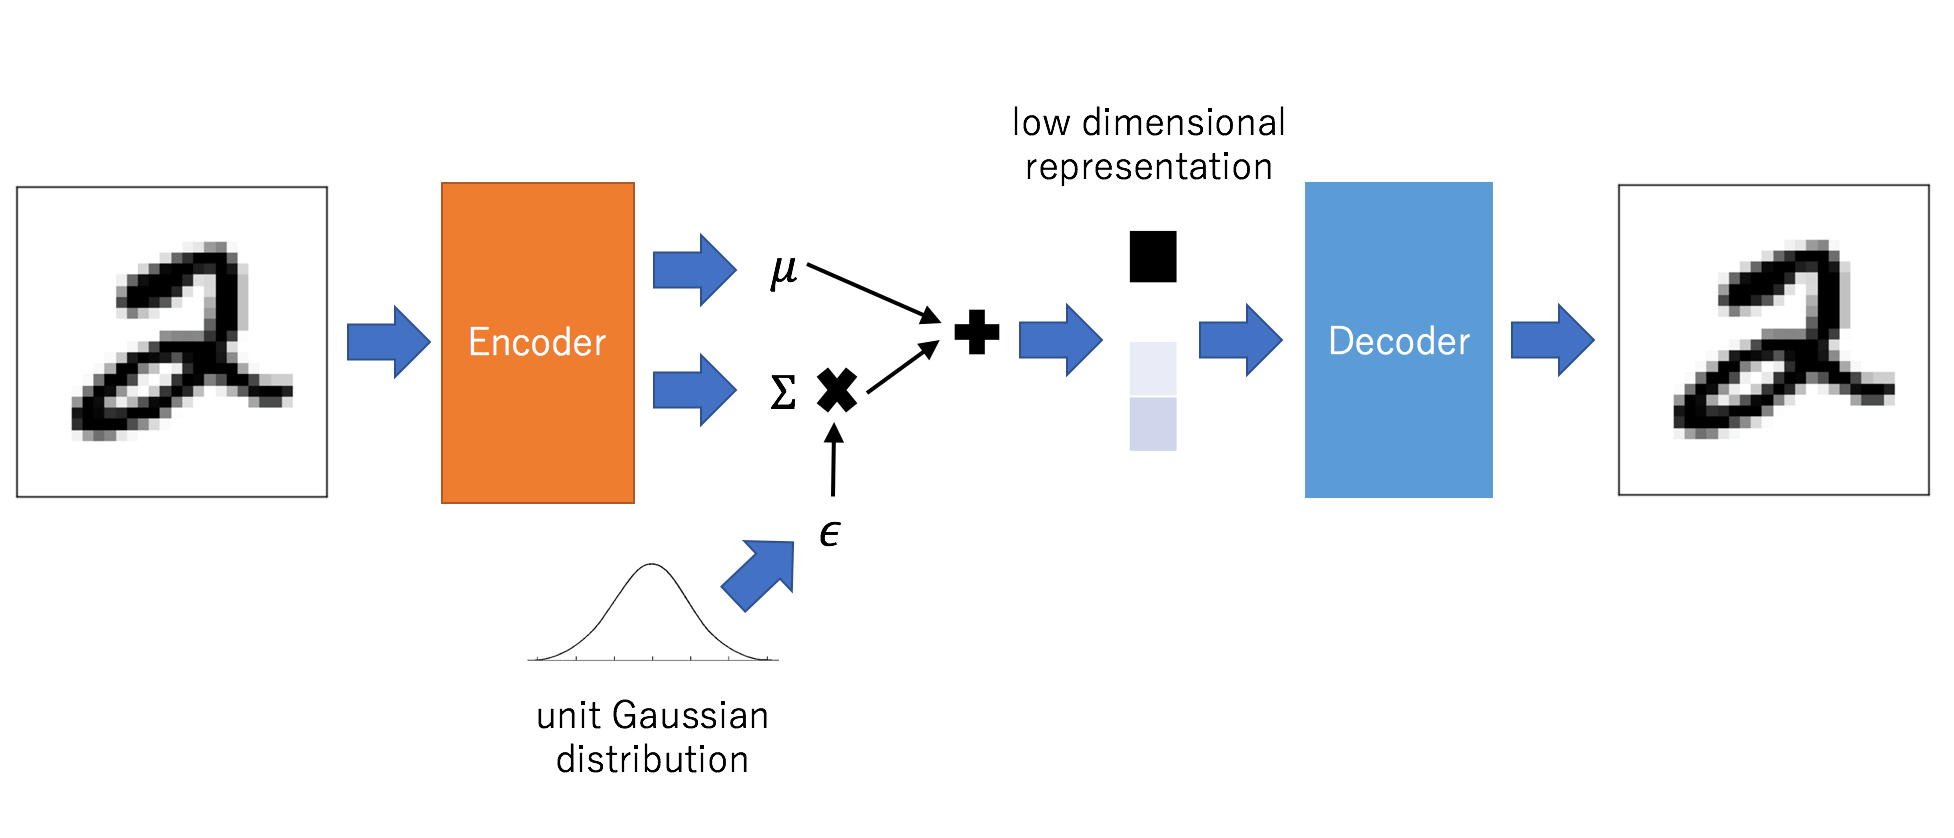

[Source: Machine Learning Explained - An Intuitive Explanation of Variational Autoencoders (VAEs Part 1)]

## Step 1 - Data and pipeline preparation
In this step, we will load MNIST training and validation datasets and prepare FastEstimator's pipeline.

In [ ]:
#training parameters
epochs = 100
batch_size = 100
steps_per_epoch = None

### Dataset

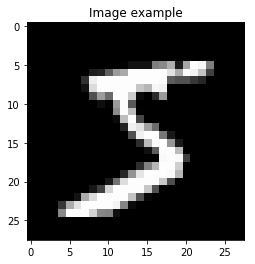

In [131]:
# Load dataset

(x_train, _), (x_eval, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

x_eval = x_eval.reshape(x_eval.shape[0], 28, 28, 1).astype('float32')

plt.imshow(x_train[0,:,:,0], cmap='gray')
plt.title('Image example')
plt.show()

### Preprocessing

In [2]:
# Define custom preprocessing functions for the Pipeline

# We create a rescaling Tensor Operation.
class Myrescale(TensorOp):

    """Normalize pixel values from uint8 to float32 between 0 and 1."""

    def forward(self, data, state):

        data = tf.cast(data, tf.float32)

        data = data / 255

        return data

# We create a Tensor Operation to binarize the input.
class Mybinarize(TensorOp):

    """Pixel values assigned to either 0 or 1 """

    def forward(self, data, state):

        data = tf.where(data >= 0.5, 1., 0.)

        return data

### Pipeline
Now, we can compile the whole data preparation process into FE pipeline, indicating the batch size, the data and preprocessing ops.

In [5]:
# We indicate in a dictionary data names for each dataset and the corresponding array.
data = {"train": {"x": x_train}, "eval": {"x": x_eval}}

# Pipeline compiles batch size, datasets and preprocessing
pipeline = fe.Pipeline(batch_size=batch_size,

                       data=data,

                       ops=[Myrescale(inputs="x", outputs="x"), Mybinarize(inputs="x", outputs="x")])

## Step 2 - Models definition

In this step, we will create and compile the two models building our CVAE : an Encoder and a Decoder. The Encoder is a Convolutional Neural Network and the Decoder uses Deconvolutional layers. The user needs to define the latent dimension of the hidden space.

In [7]:
# Parameters
LATENT_DIM = 50

### Encoder
The Encoder outputs mean and log(variance) (log for stability) of the data distribution in the latent dimension. We create a simple CNN with two convolutional layers and a fully connected layer at the end.
As the two parameters are concatenated by the fully connected layer, we define a Tensor Operation to split the Encoder output in two Tensors.

In [8]:
# Encoder network

def encoder_net():

    encoder_model = tf.keras.Sequential()

    encoder_model.add(tf.keras.layers.InputLayer(input_shape=(28, 28, 1)))

    encoder_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'))

    encoder_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'))

    encoder_model.add(tf.keras.layers.Flatten())

    encoder_model.add(tf.keras.layers.Dense(LATENT_DIM + LATENT_DIM))

    return encoder_model

# The encoder network outputs a flatten array concatenating mean and logvar,we define SplitOp to split them.

class SplitOp(TensorOp):

    """To split the infer net output into two """

    def forward(self, data, state):

        mean, logvar = tf.split(data, num_or_size_splits=2, axis=1)

        return mean, logvar


### Decoder

The Decoder is the generative part of the model. It takes as input the representation of the input in the latent space and outputs a reconstructed image. The Encoder takes as input the latent representation of the image and mirrors the Encoder. Hence, the first layer is a fully connected layer of size 7x7x32. It is then composed of two Conv2DTranspose layers (also called Deconvolutional layers).

In [10]:
# Decoder model
def generative_net():

    generative_model = tf.keras.Sequential()

    generative_model.add(tf.keras.layers.InputLayer(input_shape=(LATENT_DIM, )))

    generative_model.add(tf.keras.layers.Dense(units=7 * 7 * 32, activation=tf.nn.relu))

    generative_model.add(tf.keras.layers.Reshape(target_shape=(7, 7, 32)))

    generative_model.add(

        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'))

    generative_model.add(

        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'))

    generative_model.add(tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME"))

    return generative_model

### FEModels
We will finally compile the models thanks to FEModel and use an Adam optimizer with a learning rate of 1e-4.

In [12]:
# Prepare/Compile models

enc_model = fe.build(model_def=encoder_net,

                      model_name="encoder",

                      loss_name="loss",

                      optimizer=tf.optimizers.Adam(1e-4))

gen_model = fe.build(model_def=generative_net,

                    model_name="decoder",

                    loss_name="loss",

                    optimizer=tf.optimizers.Adam(1e-4))


## Step 3 - Network definition

In this step, we build the network, summarizing all operations of our model that are pictured in the graph above. We will first need to define the reparametrization and loss.

### Reparametrization to sample from encoder's output
Reparametrization is the trick used to sample from our parameters with operations allowing backpropagation. We will generate a white noise vector epsilon (Gaussian distribution N(0,1)) whose length is the latent dimension, multiply it with standard deviation and add the mean. 
(See Auto-Encoding Variational Bayes by Kingma and Welling) 

In [9]:
# We use reparametrization to sample from mean and logvar.

class ReparameterizepOp(TensorOp):

    """Reparameterization trick. Ensures gradients pass through the sample to the encoder parameters"""

    def forward(self, data, state):

        mean, logvar = data

        eps = tf.random.normal(shape=mean.shape)

        return eps * tf.exp(logvar * .5) + mean


### CVAE loss

To train a VAE, we have to maximize the evidence lower bound (ELBO) on the marginal log-likelihood $log p(x)$. 
In this example, we approximate the CVAE loss ELBO (evidence lower bound) with the Monte Carlo estimate:  
$log p(x|z) + log p(z) - log q(z|x)$ with $z$ sampled from $q(z|x)$.
We obtain a loss by changing the sign.

In [13]:
# The log normal pdf function will be used in the loss.

def _log_normal_pdf(sample, mean, logvar, raxis=1):

    log2pi = tf.math.log(2. * tf.constant(math.pi))

    return tf.reduce_sum(-.5 * ((sample - mean)**2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)



class CVAELoss(Loss):

    """Convolutional variational auto-encoder loss"""

    def forward(self, data, state):

        x, mean, logvar, z, x_logit = data

        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)

        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])

        logpz = _log_normal_pdf(z, 0., 0.)

        logqz_x = _log_normal_pdf(z, mean, logvar)
        
        # Changing the sign to obtain a loss
        return -(logpx_z + logpz - logqz_x)

### Network

In Network, we summarize all operations and the loss (which has by definition outputs = "loss").

In [14]:
# Defining FE network

network = fe.Network(ops=[

    ModelOp(inputs="x", model=enc_model, outputs="meanlogvar", mode=None),

    SplitOp(inputs="meanlogvar", outputs=("mean", "logvar"), mode=None),

    ReparameterizepOp(inputs=("mean", "logvar"), outputs="z", mode=None),

    ModelOp(inputs="z", model=gen_model, outputs="x_logit"),

    CVAELoss(inputs=("x", "mean", "logvar", "z", "x_logit"), mode=None, outputs="loss")

])

## Step 4 - Estimator definition and training

In this step, we define the estimator to compile the network and pipeline and indicate in traces that we want to save the best models. 

In [15]:
model_dir=tempfile.mkdtemp()

# Estimator
estimator = fe.Estimator(network=network,

                         pipeline=pipeline,

                         epochs=epochs,
                         
                         steps_per_epoch=steps_per_epoch,

                         traces=[ModelSaver(model_name="decoder", save_dir=model_dir, save_best=True),
                                 ModelSaver(model_name="encoder", save_dir=model_dir, save_best=True)])

We simply call the method fit to launch the training. Logs display for each step the loss and number of examples per second to evaluate the training speed.

In [ ]:
# Training
estimator.fit()

## Step 5 - Inferencing

After training, the model is saved to a temporary folder. we can load the model from file and do inferencing on a sample image.
You can also access the model via estimator.network.model['encoder'] .

### Load the models

In [27]:
model_path = os.path.join(model_dir, 'decoder_best_loss.h5')
trained_decoder = tf.keras.models.load_model(model_path, compile=False)

In [28]:
model_path = os.path.join(model_dir, 'encoder_best_loss.h5')
trained_encoder = tf.keras.models.load_model(model_path, compile=False)

### Select an image

In [143]:
# Select a random image from the validation dataset
selected_idx = np.random.randint(len(x_eval))

# Normalize and reshape the image
img = x_eval[selected_idx] / 255
img = np.where(img>= 0.5, 1., 0.) 
img = np.expand_dims(img, 0)

print("test image idx {}".format(selected_idx))

test image idx 3760


### Generate an image

In [144]:
# Generate an image following the network steps

mulogvar = trained_encoder(img)
mean, logvar = np.split(mulogvar,2, axis=1)
eps = tf.random.normal(shape=mean.shape)

reparametrized_img =  eps * tf.exp(logvar * .5) + mean


gen_img = trained_decoder(reparametrized_img)
bin_gen_img=np.where(gen_img>= 0.5, 1., 0.) 

### Plotting results

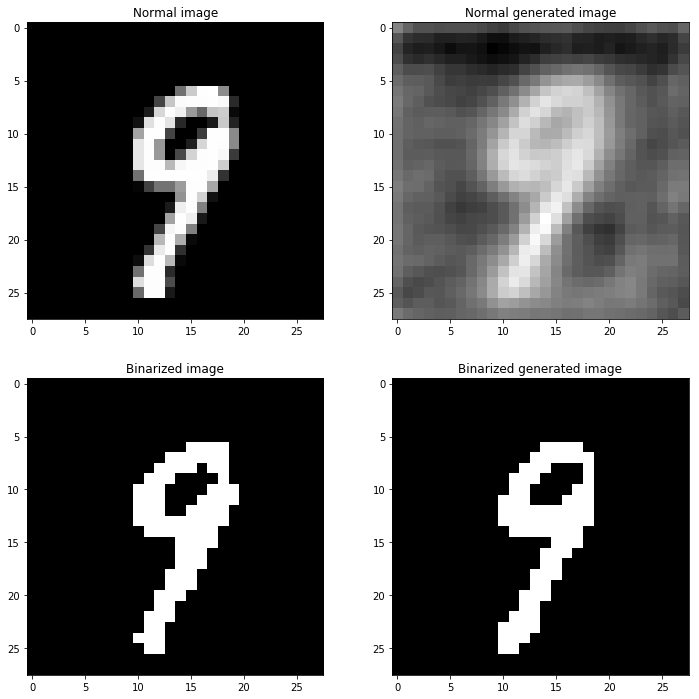

In [145]:
# Plot the results
fig, ax = plt.subplots(2,2, figsize=(12,12))

ax[0,0].imshow(x_eval[selected_idx, :, :, 0], cmap='gray')
ax[0,0].set_title('Normal image')
ax[1,0].imshow(img[0, :, :, 0], cmap='gray')
ax[1,0].set_title('Binarized image')

ax[0,1].imshow(gen_img[0,:,:,0], cmap='gray')
ax[0,1].set_title('Normal generated image')
ax[1,1].imshow(bin_gen_img[0,:,:,0], cmap='gray')
ax[1,1].set_title('Binarized generated image')
plt.show()